# Regression model for Huyndai price predidction<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_raw = pd.read_csv('hyundi.csv')

## Exploratory data analysis

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4860 non-null   object 
 1   year          4860 non-null   int64  
 2   price         4860 non-null   int64  
 3   transmission  4860 non-null   object 
 4   mileage       4860 non-null   int64  
 5   fuelType      4860 non-null   object 
 6   tax(£)        4860 non-null   int64  
 7   mpg           4860 non-null   float64
 8   engineSize    4860 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 341.8+ KB


No Nulls

In [142]:
print('Dataset size ' + str(df_raw.shape))

Dataset size (4860, 9)


In [5]:
df_raw.describe()

,year,price,mileage,tax(£),mpg,engineSize
count,4860.000000,4860.00000,4860.000000,4860.000000,4860.000000,4860.000000
mean,2017.107613,12750.13107,21486.049588,121.147119,53.827798,1.457922
std,1.920456,5992.92231,17710.196964,58.003289,12.736042,0.400788
min,2000.000000,1200.00000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,8000.00000,8339.250000,125.000000,44.800000,1.200000
50%,2017.000000,11990.00000,17462.000000,145.000000,55.400000,1.600000
75%,2019.000000,15733.75000,30967.000000,145.000000,60.100000,1.700000
max,2020.000000,92000.00000,138000.000000,555.000000,256.800000,2.900000


### Numerical feature analysis

In [6]:
df_numerical = df_raw.select_dtypes(include=['int64', 'float64'])
df_numerical.head()

,year,price,mileage,tax(£),mpg,engineSize
0,2017,7999,17307,145,58.9,1.2
1,2016,14499,25233,235,43.5,2.0
2,2016,11399,37877,30,61.7,1.7
3,2016,6499,23789,20,60.1,1.0
4,2015,10199,33177,160,51.4,2.0


In [7]:
def num_subplots_historam(df):
    
    '''
    Generates histograms for numerical features
    '''
    no_features = len(df.columns)
    
    fig, axs = plt.subplots(no_features, 1, figsize=(8, no_features*3))
    fig.tight_layout()
    
    for col, current_ax in enumerate(axs):
        
        sns.histplot(df, x=df.columns[col], ax=current_ax)
    

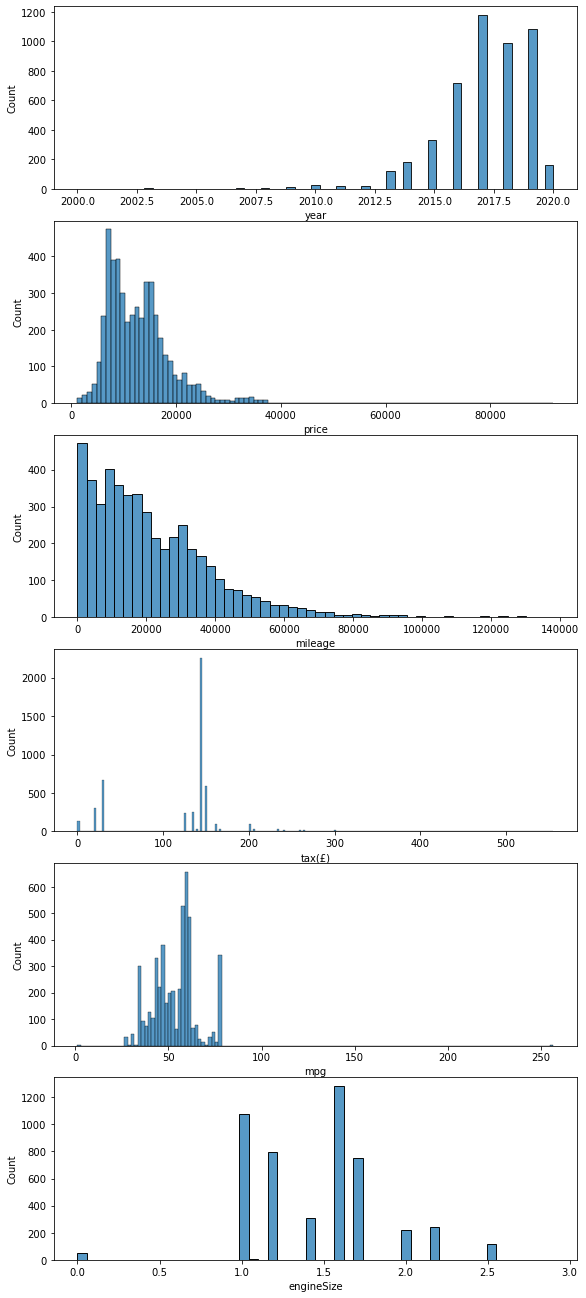

In [8]:
num_subplots_historam(df_numerical)

### Numerical correlation

<AxesSubplot:>

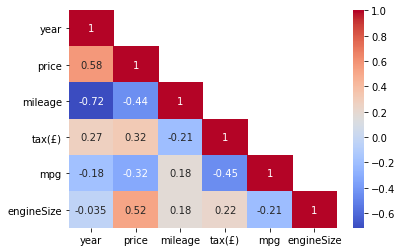

In [9]:
import numpy as np
mask = np.triu(df_numerical.corr(),k=1)

sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm', linewidths=0, linecolor='black', mask=mask)

In [10]:
# Considering impact on Price, all numerical features have relatively strong positive or negative correlation, and are worth keeping in data

### Categorical feature analysis

In [11]:
df_categorical = df_raw.select_dtypes(include=['object'])
df_categorical.head()

,model,transmission,fuelType
0,I20,Manual,Petrol
1,Tucson,Automatic,Diesel
2,Tucson,Manual,Diesel
3,I10,Manual,Petrol
4,IX35,Manual,Diesel


In [12]:
def unique_in_cat(df):
    
    return pd.DataFrame([(col, len(df[col].unique())) for col in df.columns], columns = ['feature', 'unique_vals']).set_index('feature')

In [13]:
unique_in_cat(df_categorical)

,unique_vals
feature,
model,16
transmission,4
fuelType,4


In [14]:
#Moderate amount of unique values per feature compared to dateset size

In [22]:
def cat_subplots_boxplot(df,target_value):
    
    '''
    Generates boxplots for categorical features for target value
    
    '''
    
    features = df.select_dtypes(include=['object']).columns
    no_features = len(features)
    
                                    
    fig, axs = plt.subplots(no_features, 1, figsize=(8, no_features*5))
    fig.tight_layout()
    
    
    for col, current_ax in enumerate(axs):
               
        sns.boxplot(x=features[col], y=target_value, data=df, ax=current_ax)
        current_ax.set_ylim([0,50000])

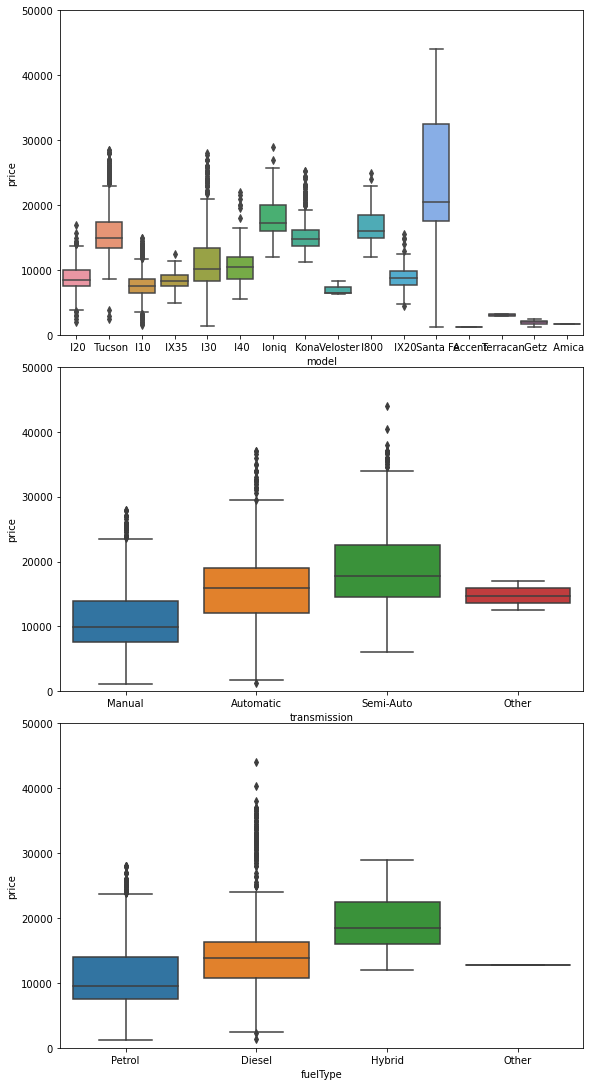

In [23]:
cat_subplots_boxplot(pd.concat([df_categorical,df_numerical['price']], axis=1),'price')

In [24]:
# Visually observable variance between categorical feeatures and price --> Worth using in model

# Regression model selection for price prediction

### Model testing 

### 1. Ridge regression - baseline for model selection

##### Data preparation

In [35]:

features = df_raw.drop('price', axis=1)
y = df_raw['price']

#OneHot to deal with categorical variables

features_onehot = pd.get_dummies(features)

#Feature scaling of (numerical) features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_scaled = StandardScaler().fit_transform(features_onehot)

#Train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.33, random_state=42)

##### Model training and scoring

In [56]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)
ridge_score = ridge.score(X_test, y_test)
print("Ridge R2 score: {:.2f}".format(ridge_score))




Ridge R2 score: 0.77


#### Ridge Feature importance for illustration 

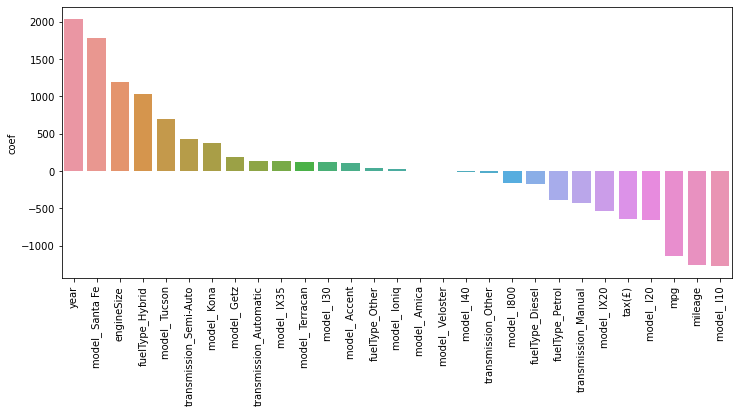

In [109]:
df_ridge_coef = pd.DataFrame(ridge.coef_, index=features_onehot.columns, columns=['coef']).sort_values('coef', ascending=False)

fig, ax = plt.subplots(figsize = (12,5))

sns.barplot(x = df_ridge_coef.index, y = 'coef', data = df_ridge_coef)
ax.tick_params(axis='x', rotation=90)

Graph shows aspects  such as: <br>
<li>The newer the car, the higher the price
<li>Santa Fe -model impacts very positively on the price
<li>The larger the Miles per Gallon, the lower the price
<li>Fuel types have quite small impact on the price, but if you have a Hybrid, you can expect a higher price
    

#### 2. Random forest

In [134]:
#OneHot
features_onehot = pd.get_dummies(features)

#Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_scaled = StandardScaler().fit_transform(features_onehot)

#Train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled, y, test_size=0.33, random_state=42)

In [135]:
from sklearn.ensemble import RandomForestRegressor

rnd_forr = RandomForestRegressor(max_depth = 2, random_state=0)
rnd_forr.fit(X_train,y_train)
rnd_forr_score = rnd_forr.score(X_test, y_test)
print('RandomForestRegressor R2 score: {:.2f}'.format(rnd_forr_score))

RandomForestRegressor R2 score: 0.57


#### 3. GradientBoostingRegressor

In [136]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train,y_train)
gbr_score = gbr.score(X_test, y_test)
print('GradientBoostingRegressor R2 score: {:.2f}'.format(gbr_score))

GradientBoostingRegressor R2 score: 0.84


# Model selection

R2-scores:

<li>Ridge: 0.77
<li>RandomForest: 0.57
<li><b>GradientBoostingRegressor: 0.84</b><br><br>
    
Obvious choise is GradientboostingRegressor with initial R2 score of 0.84

# GradientBoostingRegressor hyperparameter fine-tuning<br>

Using Grid Search with 4 options for 4 main hyperparameters

In [137]:
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }
gbr = GradientBoostingRegressor(random_state=0)

cv_gbr = GridSearchCV(gbr, parameters)
cv_gbr.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

##### Grid search took about an hour, after which we get following optimal parameter compbinations from the given search space

In [140]:
cv_gbr.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.2}

In [147]:
print('GradientBoostingRegressor best parameters: ', cv_gbr.best_params_)
print('GradientBoostingRegressor R2 score with best parameters {:.2f}'.format(cv_gbr.best_score_))

GradientBoostingRegressor best parameters:  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.2}
GradientBoostingRegressor R2 score with best parameters 0.96


##### R2 score for test set with best parameters

In [149]:
print('GradientBoostingRegressor best parameters: ', cv_gbr.score(X_test, y_test))

GradientBoostingRegressor best parameters:  0.8463108260434697


In the end not much improvement on the test set. Model is overfitting on the training set (Training R2=0.96, Test R2=0.85)<br>
Furter Improvements could surely be made if needed.